# The Price Of Gold

In [58]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark-palette')

import PyDSWS as PyDSWS
ds = PyDSWS.Datastream(username='x', password='x')

df = ds.get_data(tickers='USRAC.N, TRUSI30, GOLDBLN, S&PCOMP, NDXYSPT',
                  start="2003-01-01",end="0", freq="D")

df.columns= ['fedbs', 'us30yreal','gold','SP500',' usdollarindex']

In [59]:
df = df.ffill().dropna()
df

,fedbs,us30yreal,gold,SP500,usdollarindex
Date,,,,,
2002-12-31,689052.0,2.616,343.25,879.82,101.85
2003-01-01,689052.0,2.701,344.50,909.03,102.98
2003-01-02,689052.0,2.701,346.75,908.59,102.47
2003-01-05,689052.0,2.738,352.50,929.01,101.97
2003-01-06,689052.0,2.747,349.00,922.93,102.57
...,...,...,...,...,...
2020-07-28,6916542.0,-0.404,1955.46,3258.44,93.45
2020-07-29,6916542.0,-0.414,1940.10,3246.22,93.02
2020-07-30,6916542.0,-0.455,1975.10,3271.12,93.35


In [68]:
df.corr().round(2)[2:3]

,fedbs,us30yreal,gold,SP500,usdollarindex,linear_prediction
gold,0.77,-0.82,1.0,0.53,-0.04,0.86


In [61]:
linmodel = smf.ols('gold ~ fedbs + us30yreal + SP500', data = df).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   gold   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     4455.
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:16:37   Log-Likelihood:                -31078.
No. Observations:                4590   AIC:                         6.216e+04
Df Residuals:                    4586   BIC:                         6.219e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1650.1366     22.999     71.747      0.000    1605.047    1695.227
fedbs          0.0001   4.07e-06     34.135      0.000       0.000       0.000
us30yreal   -379.0115      8.053    -47.066      0.000    -394.799    -363.224
SP500         -0.2347      0.008    -28.959      0.000      -0.251      -0.219
==============================================================================
Omnibus:                      321.045   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.920
Skew:                           0.122   Prob(JB):                     9.11e-27
Kurtosis:                       2.247   Cond. No.                     2.42e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
df['linear_prediction'] = linmodel.predict(df)
df[['gold','linear_prediction']].round(3)

,gold,linear_prediction
Date,,
2002-12-31,343.25,547.958
2003-01-01,344.50,508.888
2003-01-02,346.75,508.991
2003-01-05,352.50,490.176
2003-01-06,349.00,488.192
...,...,...
2020-07-28,1955.46,1999.969
2020-07-29,1940.10,2006.627
2020-07-30,1975.10,2016.323


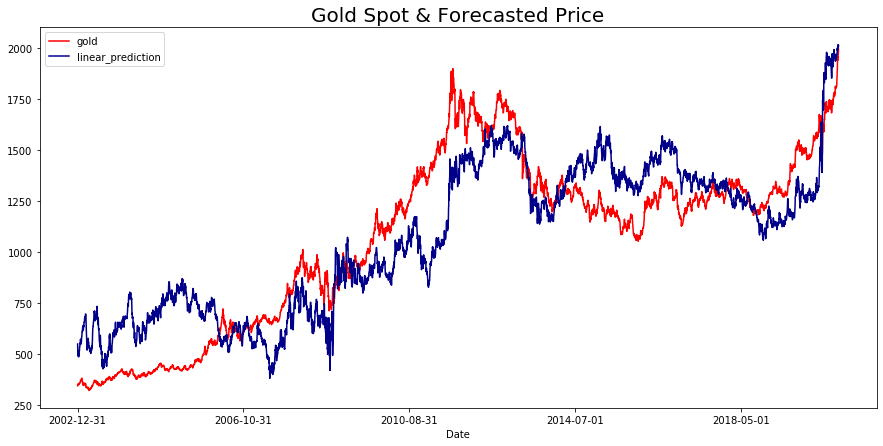

In [69]:
fig = plt.figure(figsize=(15,7))

plt.title('Gold Spot & Forecasted Price',size=20)

df['gold'].plot(color ='red', legend='gold')
df['linear_prediction'].plot(color ='darkblue',legend='linear_prediction');

Good luck with the market!

Guillaume

Fierce Research